# Shallow dive intro deep learning with fastai

This tutorial assumes you have a little-to-no experience with deep learning for computer vision. Instead of implementing anything from scratch, we will be using a power of transfer learning and superpower of [fastai](https://docs.fast.ai/quick_start.html) library.  

What will be covered:

1. Intro into jupyter notebooks and colab
2. Vectortized processing (numpy as pytorch)
3. Training image classifier
4. Training image colorizer


## Jupyter notebooks 

Jupyter notebooks (Google Colab is based on them) are json files, containing code cells, markdown cells and result cell. Jupyter calls python kernel to run the code and stores the result. Everything is rendered as HTML file.

### Google Colab

It is almost the same jupyter notebook. You can open any jupyter notebook file from github, replacing the `github` to `githubtocolab` in the browser address field:


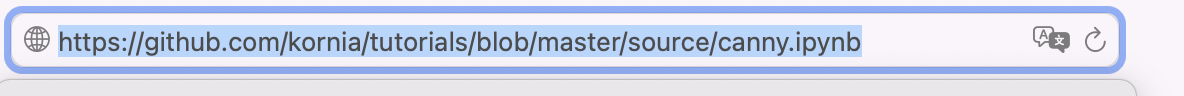

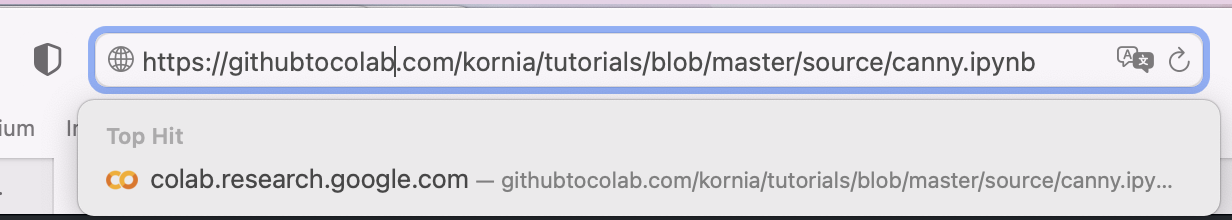

## GPU/TPU acceleration

Google Colab offers free GPU, with a limit of 9 hours per run. You go "Runtime" -> "Change runtime type" -> "GPU".
Remember, that changing runtime type resets everything, including the packages you just installed, so do it first, before running any code.

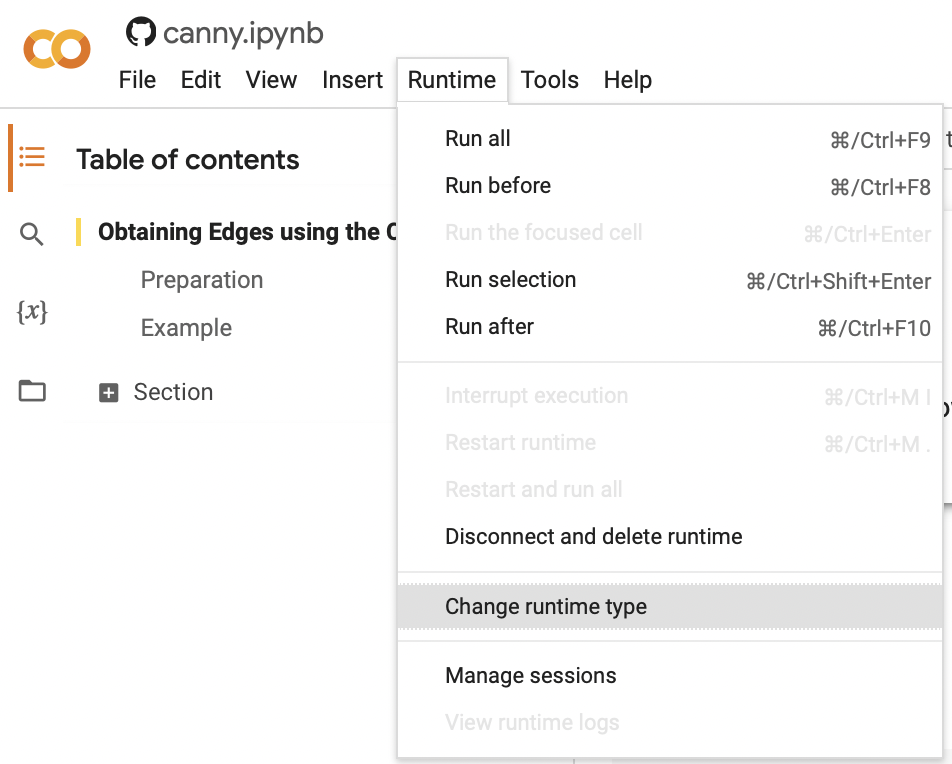

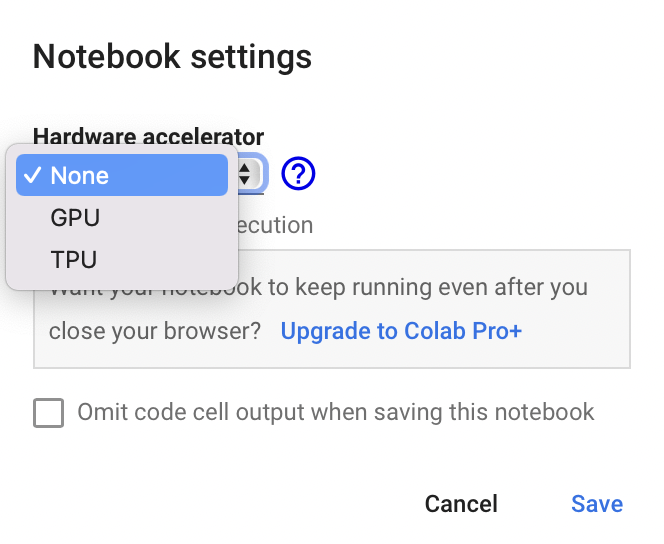

If you click on the folder icon (top left), you can see the files in the temporary file system.
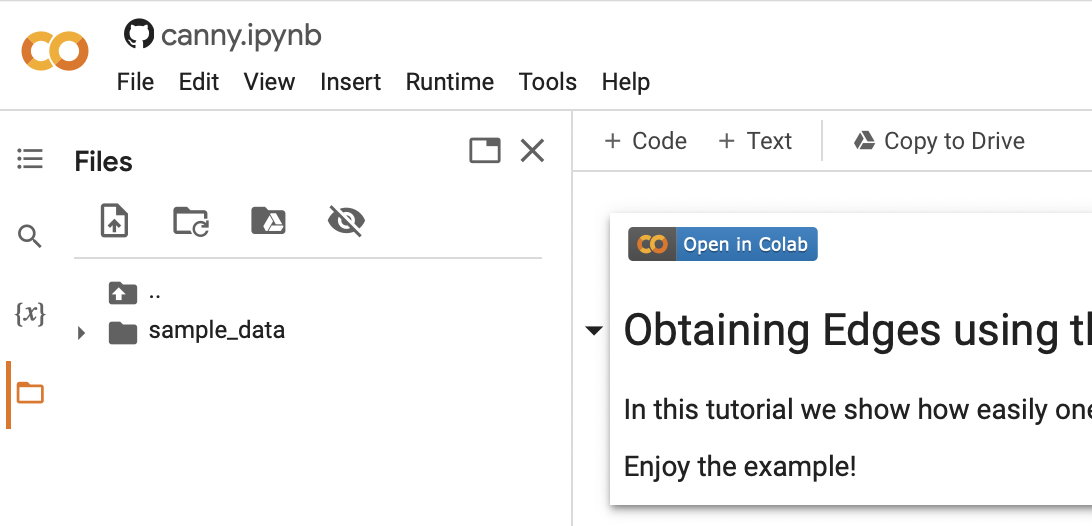


### Differences to the good old python: %magic commands

#### Autoreload

Usually, python doesn't reload packages, if you changed (edited) them without kernel restarting. ipython kernel has a way around this:

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
# Now you can edit your packages and jupyter would use the most recent version

#### inline plots

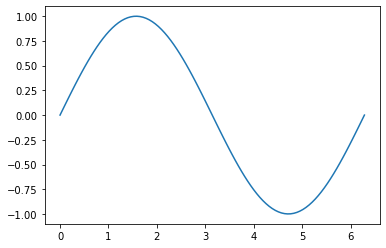

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,2*np.pi, 100), np.sin(np.linspace(0,2*np.pi, 100)))

#### console commands

In [6]:
!ls 

LICENSE                                training-colorization-GAN_files
Untitled.ipynb                         training-imagenette-CNN-fastai.ipynb
imagefiltering.ipynb                   training-imagenette-CNN.ipynb
imagenette2-160                        training-imagenette-CNN_files
imagenette2-160.tgz                    training_colorization_Unet_colab.ipynb
training-colorization-GAN.ipynb


You can also use python variables here

In [11]:
dir_list = !ls 
print(dir_list)

print ("\n Now we will print the license file: \n")
!cat {dir_list[0]}

['LICENSE', 'Untitled.ipynb', 'imagefiltering.ipynb', 'imagenette2-160', 'imagenette2-160.tgz', 'training-colorization-GAN.ipynb', 'training-colorization-GAN_files', 'training-imagenette-CNN-fastai.ipynb', 'training-imagenette-CNN.ipynb', 'training-imagenette-CNN_files', 'training_colorization_Unet_colab.ipynb']

 Now we will print the license file: 

MIT License

Copyright (c) 2022 Dmytro Mishkin

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WI

We can also install code, e.g. [kornia](https://kornia.readthedocs.io/en/latest/#).
If we don't want to see the output, we can **capture it**:

In [13]:
%%capture
!pip install kornia --no-deps

### Debug magic

In [14]:
def wrong_function(x):
    y=x+a
    a = 0
    return y
print (wrong_function(1))

UnboundLocalError: local variable 'a' referenced before assignment

In [16]:
%debug

> /var/folders/j9/y_61c9h10xz3d5g4d1rrny5c0000gn/T/ipykernel_48523/4223744977.py(2)wrong_function()
      1 def wrong_function(x):
----> 2     y=x+a
      3     a = 0
      4     return y
      5 print (wrong_function(1))

ipdb> exit


## Pytorch, numpy and parallel processing

Images are represented as multi-dimentiomal arrays

In [17]:
%%capture
!wget https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg

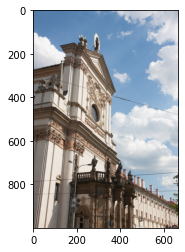

In [19]:
import matplotlib.pyplot as plt
import cv2
import torch
import numpy as np
import kornia as K

fname = 'kn_church-2.jpg'
img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
plt.imshow(img)

Image is 3-dimentional array, in OpenCV and numpy, the "color" dimention is the last one:
**Height-Width-Channels**

In [20]:
print (img.shape)

(1000, 667, 3)


Pytorch `torch.tensor` instead prefers **batch-channels-height-width**

In [24]:
timg = K.image_to_tensor(img, False).float()
print (timg.shape)

torch.Size([1, 3, 1000, 667])


The first dimension is `batch`, allowing the `batch processing`. The benefit is using the massive parallelization, built into `torch` and `numpy`.
Let's have an example.

In [25]:
def RGB_to_gray_naive(timg):
    B, CH, H, W = timg.shape
    grayscale_image = torch.zeros(B, 1, H, W)
    for b in range(B):
        for h in range(H):
            for w in range(W):
                grayscale_image[b, 0, h, w] = 0.299 * timg[b, 0, h, w] +\
                                              0.587 * timg[b, 1, h, w] +\
                                              0.114 * timg[b, 2, h, w]
    return grayscale_image

#### timeit - another useful magic command

In [26]:
%timeit gray = RGB_to_gray_naive(timg)

9.32 s ± 59.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
def RGB_vectorized(timg):
    r, g, b = torch.chunk(timg, chunks=3, dim=1)
    return 0.299 * r + 0.587 * g + 0.114 * b
gray2 = RGB_vectorized(timg)

In [32]:
%timeit gray2 = RGB_vectorized(timg)

1.1 ms ± 13.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Turning off gradients, when you don't need them

By default, Pytorch keeps the track of all the information, needed for back-propagation.
If you don't plan to learn/optimize anything, you can save memory and time, by turning them off

In [39]:
with torch.inference_mode():
    %timeit gray2 = RGB_to_gray_naive(timg)

7.7 s ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
